In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import glob
import re
#import xmltodict
import pickle
import untangle
import uuid
from tqdm import tqdm
from decimal import Decimal
from skimage import measure, morphology
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from skimage.filters import roberts, sobel

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

DATA_PATH = '/kaggle_2/lidc_idri/data/'
DATA_PATH_XML = '/kaggle_2/lidc_idri/data/tcia-lidc-xml/'
DATA_PATH_SCANS = '/kaggle_2/lidc_idri/data/LIDC/DOI/'
DATA_PATH_POST_PROCESSED_SCANS = '/kaggle_2/lidc_idri/data/scans_resampled_unsegmented/'

In [ ]:
patient_ids = set()
paths = set()
non_ct_files = set()
for filename in glob.glob(DATA_PATH_XML + '**/*.xml', recursive=True):
    with open(filename) as fd:
        doc = xmltodict.parse(fd.read())
        try:
            patient_ids.add(doc['LidcReadMessage']['ResponseHeader']['SeriesInstanceUid'])
            paths.add(doc['LidcReadMessage']['ResponseHeader']['StudyInstanceUID'] + '/' +
                      doc['LidcReadMessage']['ResponseHeader']['SeriesInstanceUid'])
        except KeyError:
            non_ct_files.add(filename)
            continue

In [38]:
patient_scans_map = {}
count = 0
for path in paths:
    [study_id, patient_id] = path.split('/')
    scan_files = glob.glob(DATA_PATH_SCANS + '**/' + path + '/*.dcm', recursive=True)
    xml_files = glob.glob(DATA_PATH_SCANS + '**/' + path + '/*.xml', recursive=True)
    patient_scans_map[patient_id] = {
        'scans': scan_files,
        'xml': xml_files
    }
    count = count + 1
    print(count, patient_id, len(scan_files), len(xml_files))

1 1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892 122 1
2 1.3.6.1.4.1.14519.5.2.1.6279.6001.199069398344356765037879821616 472 1
3 1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227 123 1
4 1.3.6.1.4.1.14519.5.2.1.6279.6001.207544473852086582434957174616 101 1
5 1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391 244 1
6 1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176 133 1
7 1.3.6.1.4.1.14519.5.2.1.6279.6001.725236073737175770730904408416 216 1
8 1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645 449 1
9 1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859 132 1
10 1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658 131 1
11 1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777 291 1
12 1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421 474 1
13 1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418 241 1
14 1.3.6.1.4.1.14519.5.2.1.6279.6001.1236543563

In [43]:
# Do NOT run this cell as it will overwrite already existing patient_scans_map file on disk
# with open(DATA_PATH + 'patient_scans_map.pkl', 'wb') as f:
#     pickle.dump(patient_scans_map, f, pickle.HIGHEST_PROTOCOL)

In [4]:
with open(DATA_PATH + 'patient_scans_map.pkl', 'rb') as f:
    patient_scans_map = pickle.load(f)

In [5]:
len(patient_scans_map)

1018

In [33]:
# Load the scans in given folder path
def load_scan(paths):
    slices = [dicom.read_file(path) for path in paths]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    origin = np.array(list(reversed(slices[0].ImagePositionPatient)), dtype=np.float32)
    
    # Determine current pixel spacing
    spacing = np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)

    return slices, origin, spacing

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

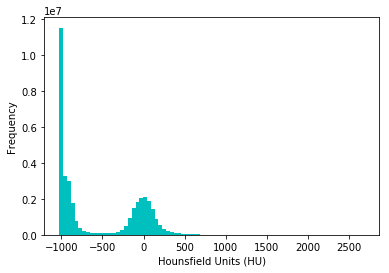

Origin [-374.73999023 -191.5        -200.3999939 ]
Spacing [ 2.5         0.74804699  0.74804699]


In [21]:
random_patient_id = list(patient_scans_map.keys())[0]
random_patient_scan_files = patient_scans_map[random_patient_id]['scans']
random_patient_scan_files.sort()
random_patient_scan, origin, spacing = load_scan(random_patient_scan_files)
random_patient_pixels = get_pixels_hu(random_patient_scan)
plt.hist(random_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
print('Origin', origin)
print('Spacing', spacing)

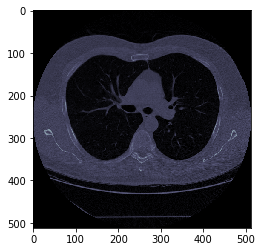

In [19]:
def plot_2d(im):
    # Show some slice in the middle
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()

# Show some slice in the middle
random_slice_index = int(np.random.random() * len(random_patient_scan))
plot_2d(random_patient_pixels[random_slice_index])

In [32]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    is_correct_order = scan[1].ImagePositionPatient[2] > scan[0].ImagePositionPatient[2]  
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = ndi.interpolation.zoom(image, real_resize_factor, order=2, mode='nearest')
    
    if not is_correct_order:
        image = np.flipud(image)
        print('Flipping image to right orientation!')
    
    return image, spacing

def resize_factor(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape

    return real_resize_factor

def get_spacing(scan):
    return np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

In [29]:
pix_resampled, spacing = resample(random_patient_pixels, random_patient_scan, [1,1,1])
print("Shape before resampling\t", random_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (141, 512, 512)
Shape after resampling	 (352, 383, 383)


In [30]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

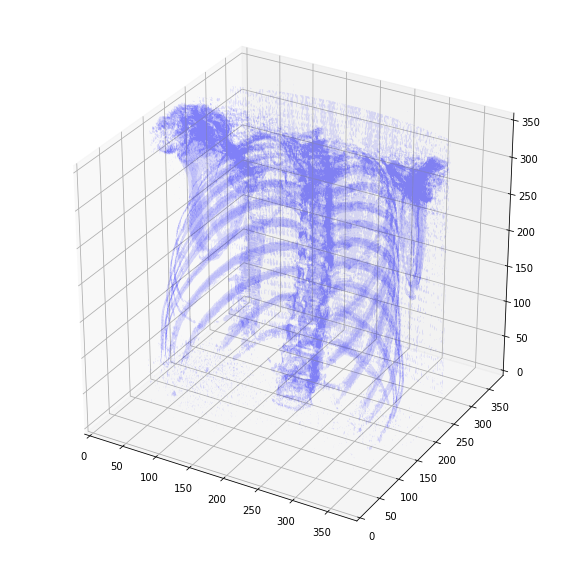

In [31]:
plot_3d(pix_resampled, 400)

In [ ]:
%%time

patients_processed_files = glob.glob(DATA_PATH_POST_PROCESSED_SCANS + 'scan_*.npy')
patients_processed = set()
for filename in patients_processed_files:
    m = re.match(r'scan_([0-9\.]*).npy', os.path.basename(filename))
    patients_processed.add(m.group(1))
    
print('Already processed ' + str(len(patients_processed)) + '/' + str(len(list(patient_scans_map.keys()))) + ' patients')

patient_count = 0
for patient_id in list(patient_scans_map.keys()):
    if patient_id in patients_processed:
        print('Skipping already processed patient ' + patient_id)
        continue
    patient_scan_files = patient_scans_map[patient_id]['scans']
    patient_scan_files.sort()
    patient_scan = load_scan(patient_scan_files)
    patient_pixels = get_pixels_hu(patient_scan)
    pix_resampled, spacing = resample(patient_pixels, patient_scan, [1,1,1])
    np.save(DATA_PATH_POST_PROCESSED_SCANS + "scan_%s.npy" % (patient_id), pix_resampled)
    print('Processed ', patient_count, ' patients')
    patient_count+=1

Already processed 1/1018 patients
Skipping already processed patient 1.3.6.1.4.1.14519.5.2.1.6279.6001.225515255547637437801620523312
Processed  0  patients
Processed  1  patients
Processed  2  patients
Processed  3  patients
Processed  4  patients
Processed  5  patients
Processed  6  patients
Processed  7  patients
Processed  8  patients
Processed  9  patients
Processed  10  patients
Processed  11  patients
Processed  12  patients
Processed  13  patients
Processed  14  patients
Processed  15  patients
Processed  16  patients
Processed  17  patients
Processed  18  patients
Processed  19  patients
Processed  20  patients
Processed  21  patients
Processed  22  patients
Processed  23  patients
Processed  24  patients
Processed  25  patients
Processed  26  patients
Processed  27  patients
Processed  28  patients
Processed  29  patients
Processed  30  patients
Processed  31  patients
Processed  32  patients
Processed  33  patients
Processed  34  patients
Processed  35  patients
Processed  3

In [34]:
sample_patient_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824'
sample_patient_scan = np.load(DATA_PATH_POST_PROCESSED_SCANS + "scan_%s.npy" % (sample_patient_id))
#plot_3d(sample_patient_scan)

In [76]:
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def has(obj, prop):
    return prop in dir(obj)

patient_nodules_map = {}
patient_non_nodules_map = {}
nodule_count = 0
non_nodule_count = 0
weird_nodule_count = 0
RESIZE_SPACING = [1,1,1]

patient_ids = list(patient_scans_map.keys())
for idx in tqdm(range(len(patient_ids))):
    patient_id = patient_ids[idx]
    patient_scan_files = patient_scans_map[patient_id]['scans']
    patient_scan_files.sort()
    patient_scan, origin, spacing = load_scan(patient_scan_files)
    patient_scan_pixels = get_pixels_hu(patient_scan)
    #patient_scan_resampled, new_spacing = resample(patient_scan_pixels, patient_scan, [1,1,1])

    xml_files = patient_scans_map[patient_id]['xml']
    
#     print(xml_files)
#     print(patient_scan_pixels.shape)
#     #print(patient_scan_resampled.shape)
#     print(origin)
#     print(spacing)

    for xml_file in xml_files:
        doc = untangle.parse(xml_file)
        readingSessionID = 0
        for readingSession in doc.LidcReadMessage.readingSession:
            readingSessionID += 1
            if has(readingSession, 'unblindedReadNodule'):
                for unblindedReadNodule in readingSession.unblindedReadNodule:
                    nodule = {}
                    rois = unblindedReadNodule.roi
                    x_min = y_min = z_min = 999999
                    x_max = y_max = z_max = -999999
                    for roi in rois:
                        inclusion = True
                        if has(roi, 'inclusion') and roi.inclusion.cdata == 'FALSE':
                            continue
                        z_min = min(z_min, float(roi.imageZposition.cdata))
                        z_max = max(z_max, float(roi.imageZposition.cdata))
                        for e in roi.edgeMap:
                            x_min = min(x_min, int(e.xCoord.cdata))
                            x_max = max(x_max, int(e.xCoord.cdata))
                            
                            y_min = min(y_min, int(e.yCoord.cdata))
                            y_max = max(y_max, int(e.yCoord.cdata))
                        if x_max == x_min:
                            continue
                        if y_max == y_min:
                            continue
                    
                    if x_max == x_min:
                            continue
                    if y_max == y_min:
                            continue
                    
                    x_diameter = x_max - x_min
                    x_center = x_min + x_diameter / 2
                    y_diameter = y_max - y_min
                    y_center = y_min + y_diameter / 2
                    z_diameter = z_max - z_min
                    z_center = z_min + z_diameter / 2
                    
                    z_center -= origin[0]
                    z_center /= spacing[0]

                    x_center_perc = round(x_center / patient_scan_pixels.shape[2], 4)
                    y_center_perc = round(y_center / patient_scan_pixels.shape[1], 4)
                    z_center_perc = round(z_center / patient_scan_pixels.shape[0], 4)

                    diameter = max(x_diameter, y_diameter)
                    diameter_perc = round(max(x_diameter / patient_scan_pixels.shape[2], y_diameter / patient_scan_pixels.shape[1]), 4)    
                                       
                    if patient_id not in patient_nodules_map or patient_nodules_map[patient_id] is None:
                        patient_nodules_map[patient_id] = []
                    if has(unblindedReadNodule, 'characteristics'):
                        if has(unblindedReadNodule.characteristics, 'malignancy'):
                            nodule['malignancy'] = float(unblindedReadNodule.characteristics.malignancy.cdata)
                        if has(unblindedReadNodule.characteristics, 'sphericity'):
                            nodule['sphericity'] = float(unblindedReadNodule.characteristics.sphericity.cdata)
                        if has(unblindedReadNodule.characteristics, 'margin'):
                            nodule['margin'] = float(unblindedReadNodule.characteristics.margin.cdata)
                        if has(unblindedReadNodule.characteristics, 'spiculation'):
                            nodule['spiculation'] = float(unblindedReadNodule.characteristics.spiculation.cdata)
                        if has(unblindedReadNodule.characteristics, 'texture'):
                            nodule['texture'] = float(unblindedReadNodule.characteristics.texture.cdata)
                        if has(unblindedReadNodule.characteristics, 'calcification'):
                            nodule['calcification'] = float(unblindedReadNodule.characteristics.calcification.cdata)
                        if has(unblindedReadNodule.characteristics, 'internal_structure'):
                            nodule['internal_structure'] = float(unblindedReadNodule.characteristics.internal_structure.cdata)
                        if has(unblindedReadNodule.characteristics, 'lobulation'):
                            nodule['lobulation'] = float(unblindedReadNodule.characteristics.lobulation.cdata)
                        if has(unblindedReadNodule.characteristics, 'subtlety'):
                            nodule['subtlety'] = float(unblindedReadNodule.characteristics.subtlety.cdata)      

                    nodule['noduleID'] = unblindedReadNodule.noduleID.cdata + '-' + str(uuid.uuid4())[0:8]
                    nodule['coords'] = [z_center, y_center, x_center]
                    nodule['coordsPerc'] = [z_center_perc, y_center_perc, x_center_perc]
                    nodule['diameter'] = diameter
                    nodule['diameterPerc'] = diameter_perc
                    nodule['readingSessionID'] = readingSessionID
                    patient_nodules_map[patient_id].append(nodule)
                    nodule_count +=1

            elif has(readingSession, 'nonNodule'):
                for nonNodule in readingSession.nonNodule:
                    if patient_id not in patient_non_nodules_map or patient_non_nodules_map[patient_id] is None:
                        patient_non_nodules_map[patient_id] = []

                    z_center = float(nonNodule.imageZposition.cdata)
                    z_center -= origin[0]
                    z_center /= spacing[0]
                    x_center = int(nonNodule.locus.xCoord.cdata)
                    y_center = int(nonNodule.locus.yCoord.cdata)
                    x_center_perc = round(x_center / patient_scan_pixels.shape[2], 4)
                    y_center_perc = round(y_center / patient_scan_pixels.shape[1], 4)
                    z_center_perc = round(z_center / patient_scan_pixels.shape[0], 4)
                    diameter_perc = round(max(6 / patient_scan_pixels.shape[2], 6 / patient_scan_pixels.shape[1]), 4)
                    non_nodule = {}
                    non_nodule['noduleID'] = nonNodule.nonNoduleID.cdata + '-' + str(uuid.uuid4())[0:8]
                    non_nodule['coords'] = [z_center, y_center, x_center]
                    non_nodule['coordsPerc'] = [z_center_perc, y_center_perc, x_center_perc]
                    non_nodule['diameter'] = diameter
                    non_nodule['diameterPerc'] = diameter_perc
                    non_nodule['readingSessionID'] = readingSessionID
                    
                    patient_non_nodules_map[patient_id].append(non_nodule)
                    non_nodule_count +=1

100%|██████████| 1018/1018 [4:32:44<00:00, 20.27s/it] 


In [75]:
patient_non_nodules_map['1.3.6.1.4.1.14519.5.2.1.6279.6001.292868422368935585625620199750']

KeyError: '1.3.6.1.4.1.14519.5.2.1.6279.6001.292868422368935585625620199750'

In [77]:
# Do NOT run this cell as it will overwrite already existing patient_nodules_map/patient_non_nodules_map file on disk
# with open(DATA_PATH + 'patient_nodules_map.pkl', 'wb') as f:
#     pickle.dump(patient_nodules_map, f, pickle.HIGHEST_PROTOCOL)
    
# with open(DATA_PATH + 'patient_non_nodules_map.pkl', 'wb') as f:
#     pickle.dump(patient_non_nodules_map, f, pickle.HIGHEST_PROTOCOL)

In [80]:
with open(DATA_PATH + 'patient_nodules_map.pkl', 'rb') as f:
    patient_nodules_map = pickle.load(f)
    
with open(DATA_PATH + 'patient_non_nodules_map.pkl', 'rb') as f:
    patient_non_nodules_map = pickle.load(f)

In [81]:
print(len(patient_nodules_map.keys()))
print(nodule_count)

883
7015


In [82]:
print(len(patient_non_nodules_map.keys()))
print(non_nodule_count)

128
1373


In [44]:
sample_patient_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986'
patient_nodules_map[sample_patient_id]
RESIZE_SPACING = [1,1,1]
patient_scan_files = patient_scans_map[sample_patient_id]['scans']
patient_scan_files.sort()
patient_scan, origin = load_scan(patient_scan_files)
patient_pixels = get_pixels_hu(patient_scan)
patient_scan_resampled, new_spacing = resample(patient_pixels, patient_scan, [1,1,1])
print('original scan shape', patient_pixels.shape)
print('resampled scan shape', patient_scan_resampled.shape)
print('origin', origin)
print('new_spacing', new_spacing)

#plot_3d(patient_pixels, 400)
print(patient_scan)
# print(patient_pixels.shape)
# print(origin)
# print(world_2_voxel(origin, origin, RESIZE_SPACING))
# pix_resampled, spacing = resample(patient_pixels, patient_scan, [1,1,1])
# print(pix_resampled.shape)
# print(patient_nodules_map['1.3.6.1.4.1.14519.5.2.1.6279.6001.143813757344903170810482790787'])

original scan shape (368, 512, 512)
resampled scan shape (368, 338, 338)
origin [-423.         -325.66992188 -166.66992188]
new_spacing [ 1.  1.  1.]
[(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.269186945647704433348133512331
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                       

In [82]:
def overlap(nodule1Coords, nodule2Coords):
    if len(nodule1Coords) == 1 and len(nodule2Coords) != 1:
        return False
    if len(nodule1Coords) != 1 and len(nodule2Coords) == 1:
        return False
    
    nodule1CoordsIncluded = nodule1Coords[nodule1Coords[:, 3] == 1.0]
    nodule2CoordsIncluded = nodule2Coords[nodule2Coords[:, 3] == 1.0]
        
    mean1Z = np.mean(nodule1CoordsIncluded[:, 0])
    mean2Z = np.mean(nodule2CoordsIncluded[:, 0])
    mean1Y = np.mean(nodule1CoordsIncluded[:, 1])
    mean2Y = np.mean(nodule2CoordsIncluded[:, 1])
    mean1X = np.mean(nodule1CoordsIncluded[:, 2])
    mean2X = np.mean(nodule2CoordsIncluded[:, 2])
    if np.abs(mean1Z - mean2Z) < 5.0 and np.abs(mean1Y - mean2Y) < 5.0 and np.abs(mean1X - mean2X) < 5.0:
        return True
    return False

patient_deduped_nodules_map = {}
deduped_nodule_count = 0
for patient_id in patient_nodules_map.keys():
    #sample_patient_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468'#list(patient_nodules_map.keys())[200]#
    #sample_patient_scan_resampled = np.load(DATA_PATH_POST_PROCESSED_SCANS + "scan_%s.npy" % (sample_patient_id))
    #xml = patient_scans_map[patient_id]['xml']
    #print(xml)
    nodules = patient_nodules_map[patient_id]

    noduleIDMap = {}
    for n in nodules:
        noduleIDMap[n['noduleID']] = n

    dupes = {}

    for n1 in nodules:
        noduleID1 = n1['noduleID']
        noduleReadingSessionID1 = n1['readingSessionID']
        nodule1Coords = np.asarray(n1['coords'])
        if noduleID1 not in dupes:
            dupes[noduleID1] = set([noduleID1])
        for n2 in nodules:
            noduleID2 = n2['noduleID']
            nodule2Coords = np.asarray(n2['coords'])
            noduleReadingSessionID2 = n2['readingSessionID']
            if noduleID1 != noduleID2 and noduleReadingSessionID1 != noduleReadingSessionID2 and overlap(nodule1Coords, nodule2Coords):
                if noduleID1 not in dupes and noduleID2 not in dupes:
                    common_set = set()
                    dupes[noduleID1] = common_set
                    dupes[noduleID2] = common_set
                elif noduleID1 in dupes and noduleID2 not in dupes:
                    dupes[noduleID2] = dupes[noduleID1]
                elif noduleID1 not in dupes and noduleID2 in dupes:
                    dupes[noduleID1] = dupes[noduleID2]
                    
                dupes[noduleID1].add(noduleID1)
                dupes[noduleID1].add(noduleID2)

    dupes_list = []
    for k1,v1 in dupes.items():
        found_dupe = False
        for v2 in dupes_list:
            if len(v1) == len(v2) and len(v1.difference(v2)) == 0:
                found_dupe = True
        if not found_dupe:
            dupes_list.append(v1)
    #print(dupes_list)
    deduped_nodules = []
    for dupe in dupes_list:
        dupe_nodules = np.asarray([noduleIDMap[nID] for nID in dupe])
        deduped_nodule = {}

        if len(dupe_nodules) > 1:
            deduped_nodule = {}        
            numCoords = len(dupe_nodules[0]['coords'])
            # Nodule < 3mm
            if numCoords == 1:
                coords = [nod['coords'][0] for nod in dupe_nodules]
                deduped_nodule['noduleID'] = dupe_nodules[0]['noduleID']
                deduped_nodule['readingSessionID'] = dupe_nodules[0]['readingSessionID']
                deduped_nodule['coords'] = [np.mean(coords, axis=0)]
            elif numCoords > 1:
                sum_malignancy = 0.0
                maxCoordsLenNodule = -1
                maxCoordsLen = 0
                for dupe_nodule in dupe_nodules:
                    if len(dupe_nodule['coords']) > maxCoordsLen:
                        maxCoordsLen = len(dupe_nodule['coords'])
                        maxCoordsLenNodule = dupe_nodule
                        sum_malignancy = sum_malignancy + dupe_nodule['malignancy']
                avg_malignancy = sum_malignancy/len(dupe_nodules)
                deduped_nodule['noduleID'] = maxCoordsLenNodule['noduleID']
                deduped_nodule['readingSessionID'] = maxCoordsLenNodule['readingSessionID']
                deduped_nodule['coords'] = maxCoordsLenNodule['coords']
                deduped_nodule['malignancy'] = avg_malignancy
        else:
            deduped_nodule = dupe_nodules[0]
        deduped_nodules.append(deduped_nodule)
        deduped_nodule_count += 1

    patient_deduped_nodules_map[patient_id] = deduped_nodules
    print('Processed patient ', patient_id)

Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414087561012670296643
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.170344311940983984999167745197
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.780558315515979171413904604168
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786
Processed patient  1.3.6.1.4.1.14519.5.2.1.6279.6001.33844714550428242214282

In [83]:
# # Do NOT run this cell as it will overwrite already existing patient_nodules_map/patient_non_nodules_map file on disk
with open(DATA_PATH + 'patient_deduped_nodules_map.pkl', 'wb') as f:
    pickle.dump(patient_deduped_nodules_map, f, pickle.HIGHEST_PROTOCOL)

In [85]:
with open(DATA_PATH + 'patient_deduped_nodules_map.pkl', 'rb') as f:
    patient_deduped_nodules_map = pickle.load(f)

In [86]:
print(len(patient_deduped_nodules_map.keys()))
print(deduped_nodule_count)

998
8419


In [87]:
# Check if inported pickle correctly. Output of this cell should match the corresponding output above
print(len(patient_deduped_nodules_map.keys()))

998


##### Finding irregular coords

In [88]:
num_patients_to_analyze = len(list(patient_deduped_nodules_map.keys()))
for patient in range(num_patients_to_analyze):
    num_nodules = len(patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]])
    for nodule in range(num_nodules):
        num_coords = len(patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]][nodule]['coords'])
        coord_type = type((patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]][nodule]['coords']))
        coord = (patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]][nodule]['coords'])
        if(not isinstance(coord, list)):
            print(list(patient_deduped_nodules_map.keys())[patient] )
            break

for the following code to work the above cell has to output 0 patient ids

###### Finding maximum size of nodules

In [89]:
num_patients_to_analyze = len(list(patient_deduped_nodules_map.keys())) #len(list(patient_deduped_nodules_map.keys()))
nodule_size = {}

for patient in range(num_patients_to_analyze):
    patient_id = list(patient_deduped_nodules_map.keys())[patient]
    num_nodules = len(patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]])
    for nodule in range(num_nodules):
        min_x, max_x, min_y, max_y, min_z, max_z = Decimal('Infinity'), Decimal('-Infinity'), Decimal('Infinity'), Decimal('-Infinity'), Decimal('Infinity'), Decimal('-Infinity')

        num_coords = len(patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]][nodule]['coords'])
        for coords in range(num_coords):
            coord = patient_deduped_nodules_map[list(patient_deduped_nodules_map.keys())[patient]][nodule]['coords'][coords]
            if coord[-1] == 1.0: # for Inclusion == TRUE only
                if (coord[0] < min_x) : min_x = coord[0]
                if (coord[1] < min_y) : min_y = coord[1] 
                if (coord[2] < min_z) : min_z = coord[2] 
                    
                if (coord[0] > max_x) : max_x = coord[0]
                if (coord[1] > max_y) : max_y = coord[1]
                if (coord[2] > max_z) : max_z = coord[2]
                
        delta_x = max_x - min_x
        delta_y = max_y - min_y
        delta_z = max_z - min_z
        nodule_size[patient_id, '- nodule:', nodule] = (delta_x, delta_y, delta_z)

In [91]:
min_delta_x, max_delta_x, min_delta_y, max_delta_y, min_delta_z, max_delta_z = Decimal('Infinity'), Decimal('-Infinity'), Decimal('Infinity'), Decimal('-Infinity'), Decimal('Infinity'), Decimal('-Infinity')
for i in list(nodule_size.keys()):
    if(nodule_size[i][0] < min_delta_x) : min_delta_x = nodule_size[i][0]
    if(nodule_size[i][1] < min_delta_y) : min_delta_y = nodule_size[i][1]
    if(nodule_size[i][2] < min_delta_z) : min_delta_z = nodule_size[i][2]
        
    if(nodule_size[i][0] > max_delta_x) : max_delta_x = nodule_size[i][0]
    if(nodule_size[i][1] > max_delta_y) : max_delta_y = nodule_size[i][1]
    if(nodule_size[i][2] > max_delta_z) : max_delta_z = nodule_size[i][2]

print('min_delta_x', min_delta_x, '| max_delta_x', max_delta_x)
print('min_delta_y', min_delta_y, '| max_delta_y', max_delta_y)
print('min_delta_z', min_delta_z, '| max_delta_z', max_delta_z)

min_delta_x 0.0 | max_delta_x 62.5
min_delta_y 0.0 | max_delta_y 65.419921875
min_delta_z 0.0 | max_delta_z 118.949996948


In [92]:
[nodule_size.values()]
deltas_flattened = [item for pair in nodule_size.values() for item in pair]

for i in range(90,101, 1):
    print('percentile', i, ':', np.percentile(deltas_flattened,i))

percentile 90 : 8.79532165527
percentile 91 : 9.296875
percentile 92 : 10.0
percentile 93 : 10.871484375
percentile 94 : 11.953125
percentile 95 : 13.1953125
percentile 96 : 15.0
percentile 97 : 17.50625
percentile 98 : 21.796875
percentile 99 : 28.359375
percentile 100 : 118.949996948


In [93]:
def nodule_inclusion_counter(chunk_size):
    nodule_included = 0
    total_nodules = len(nodule_size)
    for i in list(nodule_size.keys()):
        if nodule_size[i][0] < chunk_size and nodule_size[i][1] < chunk_size and nodule_size[i][2] < chunk_size:
            nodule_included = nodule_included + 1
    
    percent_include = nodule_included/ total_nodules 
    print('with a chunk size of', chunk_size, ', (', nodule_included, '/', total_nodules, ') included; as a percentage =', percent_include)
                
nodule_inclusion_counter(32)    

with a chunk size of 32 , ( 8308 / 8419 ) included; as a percentage = 0.9868155362869699


In [310]:
nodule_size

{('1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015',
  '- nodule:',
  1): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.299476369290630280560355838785',
  '- nodule:',
  2): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739244262091404659845',
  '- nodule:',
  1): (7.5, 16.0, 16.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058',
  '- nodule:',
  9): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.184501854685844606619543150859',
  '- nodule:',
  3): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456',
  '- nodule:',
  1): (7.5, 11.0, 9.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.207201727479884428632451006739',
  '- nodule:',
  25): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128',
  '- nodule:',
  2): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2.1.6279.6001.251204142823446211001577555181',
  '- nodule:',
  8): (0.0, 0.0, 0.0),
 ('1.3.6.1.4.1.14519.5.2